## Machine translation using encoder-decoder Seqwuence to Sequence Architecture

### Pre-requisites

- Download the data: http://www.manythings.org/anki/
- Download the word vectors: http://nlp.stanford.edu/data/glove.6B.zip

In [1]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


In [2]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

W0923 13:44:57.305853 139879995160384 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0923 13:44:57.306972 139879995160384 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0923 13:44:57.307799 139879995160384 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0923 13:44:57.330935 139879995160384 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

In [3]:
# Configuration

BATCH_SIZE=64             # Batch size for training.
EPOCHS = 4                # Number of epochs to train for.
LATENT_DIM = 256          # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000       # Number of samples to train on
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [4]:
# Where we will store the data
input_texts = []          # sentence in original language
target_texts = []         # sentence in target language
target_texts_inputs = []  # sentence in target language offset by 1

### Prepare training data

In [5]:
t = 0
for line in open('data/hin-eng/hin.txt'):
    # only keep a limited number of samples.
    t += 1
    if t > NUM_SAMPLES:
        break
        
    # input and target are separated by tab
    if '\t' not in line:
        continue
        
    # split up the input and translation
    input_text, translation = line.rstrip().split('\t')
    
    # make the target input and output using teacher forcing
    target_text = translation + '<eos>'
    target_text_input = '<sos>' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("Number of samples:", len(input_texts))

Number of samples: 2808


### Tokenize the inputs (Convert the sentences (string) into integers)

In [6]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

### Word to integer mapping for input text

In [7]:
# # get the word to index/integer mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' %len(word2idx_inputs))
print(word2idx_inputs)

Found 2388 unique input tokens.
{'the': 1, 'i': 2, 'to': 3, 'you': 4, 'is': 5, 'a': 6, 'he': 7, 'of': 8, 'in': 9, 'my': 10, 'it': 11, 'me': 12, 'this': 13, 'have': 14, 'she': 15, 'for': 16, 'was': 17, 'are': 18, 'do': 19, 'that': 20, 'his': 21, 'your': 22, 'we': 23, 'will': 24, 'on': 25, 'what': 26, "don't": 27, 'at': 28, 'him': 29, 'her': 30, 'not': 31, 'like': 32, 'go': 33, 'with': 34, 'be': 35, 'how': 36, 'and': 37, "i'm": 38, 'can': 39, 'time': 40, 'has': 41, 'there': 42, 'know': 43, 'all': 44, 'up': 45, 'they': 46, 'come': 47, 'very': 48, 'as': 49, 'had': 50, 'please': 51, 'from': 52, 'want': 53, "it's": 54, 'here': 55, 'by': 56, 'out': 57, 'am': 58, 'when': 59, 'did': 60, 'no': 61, 'been': 62, 'get': 63, "can't": 64, 'take': 65, 'going': 66, 'an': 67, 'father': 68, 'book': 69, 'if': 70, 'about': 71, 'one': 72, 'india': 73, 'were': 74, 'money': 75, 'would': 76, 'tom': 77, 'day': 78, 'long': 79, 'two': 80, 'tomorrow': 81, 'today': 82, 'where': 83, 'but': 84, 'must': 85, 'make': 86,

In [8]:
# Determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

print('max_len_input:', max_len_input)

max_len_input: 22


### Tokenize the output (Convert the sentences (string) into integers)

In [9]:
# We don't filter out special characters, otherwise <eos> and <sos> won't appear.
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
# This is an inefficient way as we are tokenizing it on the same data (target_texts and target_texts_input)
# just offset by <sos> and <eos>word2idx_outputs
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)

target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_input = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

### Word to integer mapping for output texts

In [10]:
# get the word to index mapping for output/translated language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' %len(word2idx_outputs))

print(word2idx_outputs)

Found 4095 unique output tokens.
{'में': 1, 'नहीं': 2, 'है।': 3, 'है।<eos>': 4, 'से': 5, 'के': 6, 'को': 7, 'वह': 8, 'मैं': 9, 'की': 10, 'मुझे': 11, 'का': 12, 'बहुत': 13, 'पर': 14, 'हो': 15, '<sos>मैं': 16, 'एक': 17, '<sos>वह': 18, 'कर': 19, 'लिए': 20, 'है': 21, 'हैं।': 22, 'कि': 23, 'हैं।<eos>': 24, '<sos>मुझे': 25, 'क्या': 26, 'यह': 27, 'तुम': 28, 'और': 29, 'भी': 30, 'उसने': 31, 'मेरे': 32, 'अपने': 33, 'हूँ।<eos>': 34, 'हूँ।': 35, 'रहा': 36, 'ने': 37, 'उसे': 38, '<sos>उसने': 39, 'था।<eos>': 40, 'था।': 41, 'तो': 42, 'पास': 43, 'क्या?<eos>': 44, 'क्या?': 45, 'इस': 46, 'करने': 47, 'ही': 48, 'काम': 49, 'अपनी': 50, 'मेरी': 51, 'कल': 52, 'है?': 53, 'कोई': 54, 'है?<eos>': 55, 'करना': 56, '<sos>तुम': 57, 'घर': 58, 'साथ': 59, 'समय': 60, 'सकते': 61, 'गया': 62, 'बात': 63, 'उसके': 64, 'रही': 65, 'पता': 66, 'मैंने': 67, 'उस': 68, '<sos>यह': 69, 'तुम्हारे': 70, 'उसकी': 71, 'तुम्हें': 72, 'बजे': 73, 'तक': 74, 'हैं': 75, 'मेरा': 76, 'किताब': 77, 'लगता': 78, 'पसंद': 79, 'हम': 80, 'अच्छा': 81, 'रहे': 8

In [11]:
# store number of output words for later. remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
print('num_words_output:', num_words_output)

# determine the maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print ('Maximum length of target/translated text is:', max_len_target)

num_words_output: 4096
Maximum length of target/translated text is: 25


### Pad Sequences

In [12]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_inputs.shape:', encoder_inputs.shape)
print('encoder_inputs[0]:', encoder_inputs[0])

encoder_inputs.shape: (2808, 22)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1274]


In [13]:
decoder_inputs = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')
# 26 is the maximum length of the sentence in the translated data in the training set
print('decoder_inputs.shape:', decoder_inputs.shape)
print('decoder_inputs[0]:', decoder_inputs[0])

decoder_inputs.shape: (2808, 25)
decoder_inputs[0]: [3495    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [14]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print('decoder_targets.shape:', decoder_targets.shape)
print('decoder_targets[0]:', decoder_targets[0])

decoder_targets.shape: (2808, 25)
decoder_targets[0]: [3055    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


### Load pre-trained word vectors - Embeddings

In [15]:
print('Loading word vectors')
word2vec = {}
# Load word vector of 100 dimensions.
with open (os.path.join('Embeddings/glove.6B/glove.6B.%sd.txt' %EMBEDDING_DIM)) as f:
    for line in f:
        # split at spaces
        values = line.split()
        word = values[0]
        #np.asarray Converts the input to an array.
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
print('Found %s word vectors.' %len(word2vec))
print('Embedding dimensions: ', word2vec['the'].shape)

Loading word vectors
Found 400000 word vectors.
Embedding dimensions:  (100,)


### Prepare Embedding matrix

In [16]:
print('Filling pre-trained embeddings')
# MAX_NUM_WORDS = 20000
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not foun20000d in the embedding index will all be zero
            embedding_matrix[i] = embedding_vector

print('num_words:', num_words)
# 2389 words each of 100 dimensions
print('Shape of Embeddings matrix: ', embedding_matrix.shape)

Filling pre-trained embeddings
num_words: 2389
Shape of Embeddings matrix:  (2389, 100)


### Embedding layer

In [17]:
embedding_layer = Embedding(num_words, 
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = max_len_input,
                           #trainable=true
                           )

W0923 13:45:07.222262 139879995160384 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### Build Encoder-decoder LSTM model

In [19]:
encoder_inputs_placeholder = Input(shape=(max_len_input, ))
x = embedding_layer(encoder_inputs_placeholder)

encoder_lstm = LSTM(
    LATENT_DIM,
    return_state=True,
    dropout=0.5
)

encoder_outputs, h, c = encoder_lstm(x)

# keep only the states to pass into decoder
encoder_states = [h,c]

# setup the decoder, using [h,c] as initial state
decoder_inputs_placeholder = Input(shape=(max_len_target, ))

# this word embedding will not use pre-trained vectors although we could
decoder_embedding_layer = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs_placeholder)

decoder_lstm = LSTM(
        LATENT_DIM, 
        return_sequences=True,
        return_state=True,
        dropout = 0.5
    )

decoder_outputs, _, _ = decoder_lstm(
                          decoder_inputs_x,
                          initial_state=encoder_states
                        )

print('num_words_output:', num_words_output)

# Final dense layers
decoder_dense  = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

W0923 13:45:07.573874 139879995160384 deprecation.py:506] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


num_words_output: 4096


### Compile the model

In [20]:
model.compile(
        optimizer = 'rmsprop',
        loss='categorical_crossentropy',
        metrics=['acc'])

W0923 13:45:08.169140 139879995160384 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Training Model

In [21]:
history = model.fit(
    [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

W0923 13:45:08.307160 139879995160384 deprecation.py:323] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2246 samples, validate on 562 samples
Epoch 1/4
2246/2246 [==============================] - 23s 10ms/step - loss: 2.4872 - acc: 0.7395 - val_loss: 2.8392 - val_acc: 0.6073
Epoch 2/4
2246/2246 [==============================] - 18s 8ms/step - loss: 1.5847 - acc: 0.7647 - val_loss: 2.7734 - val_acc: 0.6093
Epoch 3/4
2246/2246 [==============================] - 21s 9ms/step - loss: 1.4707 - acc: 0.7696 - val_loss: 2.7273 - val_acc: 0.6215
Epoch 4/4
2246/2246 [==============================] - 18s 8ms/step - loss: 1.3834 - acc: 0.7802 - val_loss: 2.5859 - val_acc: 0.6400


### Visualize accuracy and loss curves

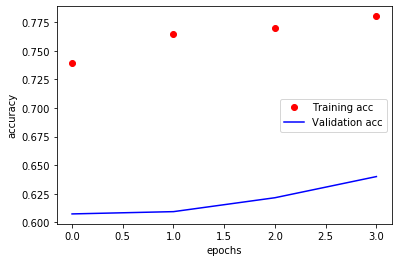

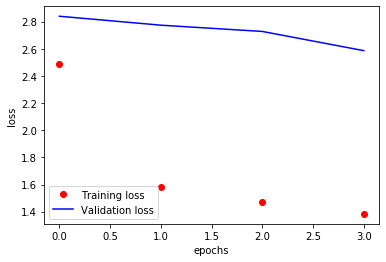

<Figure size 432x288 with 0 Axes>

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('static/acc_machine_translation_lstm.png')
plt.show()
plt.clf()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('static/loss_machine_translation_lstm.png')
plt.show()
plt.clf()

### Make predictions

In [23]:
# create another model that can take in the RNN state and previous word as input and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [24]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [25]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

KeyError: '<sos>'